Some useful libraries:

In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from yellowbrick.cluster import KElbowVisualizer

We load the starting dataset features such that at the end of the clustering we can add a column in it containing cluster indices for each costumer:

In [94]:
features = pd.read_csv("features.csv")
features=features.drop(['Unnamed: 0'], axis=1)

In [54]:
# Load the dataframe obtained from the PCA in the previous exercise
data = pd.read_csv('pca_features.csv')
data=data.drop(['Unnamed: 0'], axis=1)
data = data.values
data

array([[ 0.02159565,  0.37953109, -0.02801758,  0.15395317],
       [-0.07346689, -0.04242453, -0.1093801 , -0.11240164],
       [-0.11900419,  0.28492005,  0.27558898, -0.0786157 ],
       ...,
       [ 0.08943892, -0.05039707, -0.10210086, -0.05800698],
       [-0.14862432, -0.03563719, -0.11919064, -0.04942727],
       [ 0.22495462, -0.04799951, -0.08238435, -0.04938467]])

# 2.3 Clustering!

## Implement the K-means clustering algorithm (not ++: random initialization). We ask you to write the algorithm from scratch following what you learned in class. !! We also ask you to use MapReduce in your K-means algorithm.

In [92]:
k = 4 #optimal number of clusters found with the Elbow method below

# First, we randomly initialize the centroids
centroids = np.random.rand(k, data.shape[1])

# Then, we define a function to compute the distance between two points
def distance(p1, p2):
    return np.sqrt(np.sum((p1 - p2)**2))

# Define a function to assign each data point to the closest centroid
def assign_points_to_clusters(data, centroids):
    clusters = []
    for point in data:
        distances = [distance(point, centroid) for centroid in centroids]
        cluster_idx = np.argmin(distances)
        clusters.append(cluster_idx)
    return clusters

# Define a function to update the centroids
def update_centroids(data, clusters, centroids):
    for i in range(k):
        cluster_points = [data[j] for j in range(len(data)) if clusters[j] == i]
        centroids[i] = np.mean(cluster_points, axis=0)

# Define a function to run the k-means algorithm
def my_kmeans(data, k, centroids):
    # Repeat the following steps until convergence
    while True:
        # Assign each point to the closest centroid
        clusters = assign_points_to_clusters(data, centroids)

        # Store the old centroids
        old_centroids = centroids.copy()

        # Update the centroids
        update_centroids(data, clusters, centroids)

        # Check for convergence
        if np.array_equal(old_centroids, centroids):
            break

# Define the MapReduce function
def map_reduce(data, map_func, reduce_func):
    # Divide the data into chunks
    chunks = np.array_split(data, 4) #4 is the number of cores of my computer

    # Map the data
    mapped_data = []
    for chunk in chunks:
        mapped_data.append(map_func(chunk))

    # Reduce the data
    reduced_data = reduce_func(mapped_data)

    return reduced_data

# Define the map function
def map_kmeans(chunk):
    # Initialize the centroids
    local_centroids = np.random.rand(k, data.shape[1])

    # Run the k-means algorithm
    my_kmeans(chunk, k, local_centroids)

    return local_centroids

# Define the reduce function
def reduce_kmeans(local_centroids):
    
    # Compute the global centroids
    global_centroids = np.mean(local_centroids, axis=0)

    return global_centroids

## Find an optimal number of clusters. Use at least two different methods. If your algorithms provide diverse optimal K's, select one of them and explain why you chose it.

To find the optimal number of clusters in the k-means algorithm, it is possible to use the following methods:

### The elbow method:

The WCSS is a measure of the compactness of the clusters, with smaller values indicating better clustering. The elbow method involves plotting the WCSS against k, and selecting the value of k where the WCSS starts to decrease more slowly. This value of k is considered to be the optimal number of clusters.

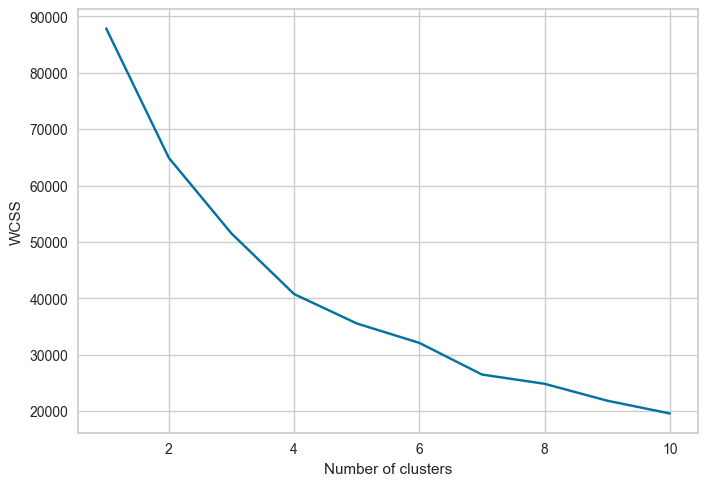

In [62]:
# Create an empty list to store the WCSS values
WCSS = []

# Loop over different values of i
for i in range(1, 11):
    # Create a k-means model with the current value of i
    kmeans_py = KMeans(n_clusters=i)

    # Fit the model to the data
    kmeans_py.fit(data)

    # Compute the WCSS for the current model
    WCSS.append(kmeans_py.inertia_)

# Plot the WCSS values
plt.plot(range(1, 11), WCSS)
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

As we can see from the graph, the optimal number of clusters following the Elbow method is 4.

### The silhouette coefficient

The silhouette coefficient method involves computing the average silhouette coefficient for each value of k, and selecting the value of k that produces the highest average silhouette coefficient. This value of k is considered to be the optimal number of clusters.

In [55]:
# Create an empty list to store the silhouette coefficients
silhouette_coefficients = []

# Loop over different values of k
for k in range(2, 9):
    # Create a k-means model with the current value of k
    kmeans = KMeans(n_clusters=k)

    # Fit the model to the data
    kmeans.fit(data)

    # Compute the silhouette coefficient for the current model
    silhouette_coefficients.append(silhouette_score(data, kmeans.labels_))

# Plot the silhouette coefficient values
plt.plot(range(2, 9), silhouette_coefficients)
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette coefficient')
plt.show()

KeyboardInterrupt: 

We tried to implement the silhouette coefficient method but we don't know why it takes too much time to run, so we had to interrupt it. So, in the end, we chose 4 as number of clusters as visualized in the graph of the Elbow Method.

### Run the algorithm on the data.

In [27]:
# Run the MapReduce function
global_centroids=map_reduce(data, map_kmeans, reduce_kmeans)

 We save them in an external file such that we don't have to run the code every time for several minutes

In [29]:
np.savetxt('global_centroids.csv', global_centroids, delimiter=',')

Once we get global centroids computed by the k-means algorithm, we use them to cluster the data points into the specified number of clusters.
The assign_points_to_clusters function only assigns the data points to the closest cluster based on the given centroids. It does not compute the final clusters or update the centroids. To compute the final clusters and update the centroids, we need to run the kmeans function before calling the assign_points_to_clusters function. This will run the k-means algorithm and update the centroids until convergence, and then the assign_points_to_clusters function can be used to assign the data points to the clusters based on the final centroids.

In [30]:
# Run the k-means algorithm to compute the final clusters and update the centroids for my data
my_kmeans(data, k, global_centroids)

In [31]:
# Assign the data points to the closest cluster
cluster_indices = assign_points_to_clusters(data, global_centroids)

In [96]:
cluster_indices

[1,
 3,
 0,
 2,
 3,
 3,
 1,
 0,
 3,
 3,
 2,
 0,
 1,
 2,
 1,
 2,
 3,
 2,
 2,
 3,
 0,
 3,
 3,
 3,
 3,
 3,
 0,
 1,
 0,
 2,
 1,
 0,
 0,
 3,
 1,
 2,
 0,
 3,
 3,
 2,
 3,
 2,
 0,
 3,
 0,
 2,
 3,
 3,
 3,
 0,
 3,
 2,
 3,
 2,
 2,
 2,
 3,
 3,
 3,
 3,
 0,
 3,
 0,
 0,
 2,
 2,
 3,
 3,
 1,
 1,
 3,
 2,
 3,
 3,
 2,
 1,
 3,
 3,
 3,
 2,
 2,
 3,
 2,
 3,
 0,
 3,
 0,
 0,
 3,
 0,
 3,
 3,
 3,
 2,
 3,
 3,
 0,
 3,
 2,
 3,
 3,
 1,
 1,
 3,
 0,
 1,
 3,
 3,
 2,
 2,
 1,
 3,
 3,
 3,
 1,
 1,
 3,
 3,
 3,
 0,
 2,
 2,
 0,
 0,
 2,
 2,
 0,
 3,
 3,
 3,
 3,
 3,
 2,
 1,
 2,
 0,
 2,
 2,
 0,
 0,
 2,
 3,
 2,
 2,
 2,
 3,
 3,
 2,
 1,
 3,
 3,
 2,
 2,
 3,
 2,
 2,
 3,
 0,
 0,
 2,
 1,
 2,
 0,
 2,
 3,
 0,
 1,
 3,
 2,
 2,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 2,
 3,
 1,
 2,
 3,
 1,
 3,
 2,
 2,
 2,
 0,
 1,
 3,
 0,
 2,
 2,
 3,
 3,
 3,
 3,
 0,
 3,
 0,
 0,
 3,
 3,
 2,
 3,
 3,
 3,
 3,
 3,
 3,
 1,
 3,
 3,
 2,
 0,
 3,
 2,
 2,
 2,
 2,
 3,
 1,
 2,
 1,
 3,
 3,
 3,
 3,
 0,
 1,
 3,
 0,
 3,
 3,
 3,
 2,
 2,
 0,
 2,
 3,
 3,
 2,
 3,
 2,
 2,
 2,
 1,
 2,
 1,
 0,


In [98]:
#We add this cluster indices array as a column of our starting dataset "features"
features['clus_ind']=0
for i in range(len(features)):
    features['clus_ind'][i]=cluster_indices[i]

C:\Users\feder\AppData\Local\Temp\ipykernel_15488\3730380774.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features['clus_ind'][i]=cluster_indices[i]


In [99]:
#then, we save it as a csv file
features.to_csv('features.csv')

### Then, use the already implemented version of K-means++ (from the scikit-learn library). Explain the differences (if there are any) in the results.

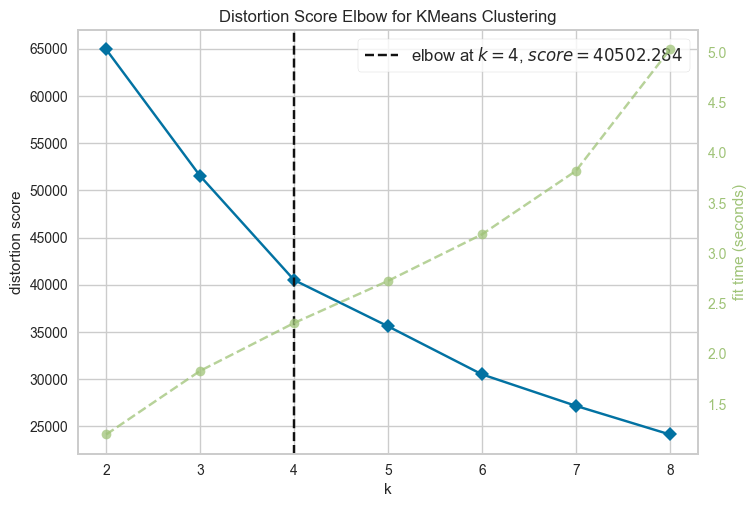

<AxesSubplot: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [59]:
model = KMeans(init='k-means++')
visualizer = KElbowVisualizer(model, k = (2,9), metric = "distortion")
visualizer.fit(data)
visualizer.show()

As can be seen in the graph of the already implemented method of K-means, the elbow of python implemented version of K-means is the same as above, getting 4 as optimal cluster number. 